In [13]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Conv2D, Activation
from tensorflow.keras.layers import BatchNormalization, Input
from tensorflow.keras.backend import concatenate
import tensorflow as tf
from official.vision.image_classification.efficientnet import efficientnet_model



def layer1_multistream(res_x, res_y, num_cams, filter_num, filter_size):
    """
    Multi-stream layer: Conv - ReLU - Conv - ReLU - BN

    :param res_x:
    :param res_y:
    :param num_cams:
    :param filter_num:
    :return:
    """
    if not hasattr(layer1_multistream, "instance"):
        layer1_multistream.instance = 0
    j = layer1_multistream.instance
    seq = Sequential()
    seq.add(Conv2D(filter_num, (filter_size, filter_size),
                   input_shape=(res_x, res_y, num_cams),
                   padding='valid', name=f'S1_C10_{j}', activation='relu'))
    seq.add(Conv2D(filter_num, (filter_size, filter_size),
                   input_shape=(res_x-2*(filter_size//2), res_y-2*(filter_size//2), 70),
                   padding='valid', name=f'S1_C20_{j}'))
    seq.add(BatchNormalization(axis=-1, name=f'S1_BN0_{j}'))
    seq.add(Activation('relu'))

    seq.add(Conv2D(filter_num, (filter_size, filter_size),
                   input_shape=(res_x-4*(filter_size//2), res_y-4*(filter_size//2), 70),
                   padding='valid', name=f'S1_C11_{j}', activation='relu'))
    seq.add(Conv2D(filter_num, (filter_size, filter_size),
                   input_shape=(res_x-6*(filter_size//2), res_y-6*(filter_size//2), 70),
                   padding='valid', name=f'S1_C21_{j}'))
    seq.add(BatchNormalization(axis=-1, name=f'S1_BN1_{j}'))
    seq.add(Activation('relu'))

    seq.add(Conv2D(filter_num, (filter_size, filter_size),
                   input_shape=(res_x-8*(filter_size//2), res_y-8*(filter_size//2), 70),
                   padding='valid', name=f'S1_C12_{j}', activation='relu'))
    seq.add(Conv2D(filter_num, (filter_size, filter_size),
                   input_shape=(res_x-10*(filter_size//2), res_y-10*(filter_size//2), 70),
                   padding='valid', name=f'S1_C22_{j}'))
    seq.add(BatchNormalization(axis=-1, name=f'S1_BN2_{j}'))
    seq.add(Activation('relu'))
    layer1_multistream.instance += 1
    seq.trainable = True
    return seq


def efficientnet(filter_num):
    """
    Merged layer: Conv - ReLU - Conv - ReLU - BN

    :return: seq:
    """
    block_config = efficientnet_model.BlockConfig()
    
    blocks =  (# (input_filters, output_filters, kernel_size, num_repeat,
              #  expand_ratio, strides, se_ratio)
              block_config.from_args(140, 70, 3, 1, 1, (1, 1), 0.25),
              block_config.from_args(70, 50, 3, 2, 6, (2, 2), 0.25),
              block_config.from_args(50, 40, 5, 2, 6, (2, 2), 0.25),
              block_config.from_args(40, 80, 3, 3, 6, (2, 2), 0.25),
              block_config.from_args(80, 112, 5, 3, 6, (1, 1), 0.25),
              block_config.from_args(112, 192, 5, 4, 6, (2, 2), 0.25),
              block_config.from_args(192, 320, 3, 1, 6, (1, 1), 0.25),
             )

    seq = efficientnet_model.EfficientNet(overrides={'num_classes': 3,
                                                     'input_channels': filter_num*2,
                                                     'rescale_input': False,
                                                     'blocks':blocks,
                                                     'width_coefficient':1.0,
                                                     'stem_base_filters':140})
    seq.trainable = True
    return seq


def define_epidef(sz_input1, sz_input2, view_n, filter_num):
    """
    Compiles the full network.

    :param sz_input1: resX
    :param sz_input2: resY
    :param view_n: num_cams
    :param filter_num: number of channels in multistream layers
    :return:
    """
    # 2-Input: Conv - ReLU - Conv - ReLU - BN
    input_stack_vert = Input(shape=(sz_input1, sz_input2, view_n), name='input_stack_vert')
    input_stack_hori = Input(shape=(sz_input1, sz_input2, view_n), name='input_stack_hori')

    # 2-Stream layer: Conv - ReLU - Conv - ReLU - BN
    mid_vert = layer1_multistream(sz_input1, sz_input2, view_n, filter_num, 5)(input_stack_vert)
    mid_hori = layer1_multistream(sz_input1, sz_input2, view_n, filter_num, 5)(input_stack_hori)

    # Merge layers
    mid_merged = concatenate([mid_vert, mid_hori])
    mid_merged_ = efficientnet(filter_num)

    output = mid_merged_(mid_merged)
    model_512 = Model(inputs=[input_stack_vert, input_stack_hori], outputs=[output])
    metrics = ['accuracy',
               tf.keras.metrics.Precision(name='precision'),
               tf.keras.metrics.Recall(name='recall')]
    model_512.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metrics)
    model_512.summary()
    return model_512


In [14]:
import os
import datetime
import numpy as np

import tensorflow as tf
from tensorflow import keras
from epidef_fun.util import get_list_ids
from epidef_fun.DataGenerator import DataGenerator


network_name = 'EPIDef_train'
iter00 = 0
load_weights = False
"""
Model parameters:
    first layer:  3 convolutional blocks
    second layer: 6 convolutional blocks
    last layer:   1 dense block?
"""
model_filter_number = 70
model_learning_rate = 1e-5
batch_size = 2
input_res = 248



# Load training data from lightfield .png files:
print("Loading lightfield paths...")
dir_lf_images = ("C:\\Users\\rmueller\\Google Drive\\University\\Master_Project"
                 + "\\data_storage\\lightfields_nohdr")
# dir_lf_images = ("C:\\Users\\muell\\Desktop\\blender_output_tmp")
list_ids = get_list_ids(dir_lf_images)[:500]

print("Done loading lightfield paths.")
fraction = np.int(len(list_ids)*0.7)
list_ids_train, list_ids_test = list_ids[:fraction], list_ids[fraction:]

model = define_epidef(input_res, input_res, 7, model_filter_number)

generator_train = DataGenerator(list_ids_train, batch_size=batch_size, train=False)
generator_test = DataGenerator(list_ids_test, batch_size=batch_size, train=False)

Loading lightfield paths...
Good: 0.5763846622032867
Scratch: 0.21343071616960843
Dent: 0.21018462162710488
Error: 0.0
Done loading lightfield paths.
Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_stack_vert (InputLayer)   [(None, 248, 248, 7) 0                                            
__________________________________________________________________________________________________
input_stack_hori (InputLayer)   [(None, 248, 248, 7) 0                                            
__________________________________________________________________________________________________
sequential_10 (Sequential)      (None, 224, 224, 70) 626010      input_stack_vert[0][0]           
__________________________________________________________________________________________________
sequential_11 (Sequential)      (Non

In [15]:
model.fit(generator_train, epochs=10, max_queue_size=10, initial_epoch=iter00, verbose=2,
          validation_data=generator_test)

Epoch 1/10


175/175 - 109s - loss: 5.1439 - accuracy: 0.3857 - precision: 0.3844 - recall: 0.3800 - val_loss: 1469.1959 - val_accuracy: 0.3200 - val_precision: 0.3200 - val_recall: 0.3200
Epoch 2/10
175/175 - 115s - loss: 1.9547 - accuracy: 0.4543 - precision: 0.4540 - recall: 0.4086 - val_loss: 1.6020 - val_accuracy: 0.4800 - val_precision: 0.4892 - val_recall: 0.4533
Epoch 3/10
175/175 - 117s - loss: 1.7330 - accuracy: 0.4514 - precision: 0.4339 - recall: 0.3657 - val_loss: 1.5906 - val_accuracy: 0.5000 - val_precision: 0.4966 - val_recall: 0.4933
Epoch 4/10
175/175 - 118s - loss: 1.7381 - accuracy: 0.4171 - precision: 0.4238 - recall: 0.3657 - val_loss: 2.3275 - val_accuracy: 0.3800 - val_precision: 0.3511 - val_recall: 0.3067
Epoch 5/10
175/175 - 117s - loss: 1.5325 - accuracy: 0.4600 - precision: 0.4764 - recall: 0.4029 - val_loss: 2.0476 - val_accuracy: 0.5067 - val_precision: 0.5000 - val_recall: 0.4867
Epoch 6/10
175/175 - 119s - loss: 1.5638 - accuracy: 0.4400 - precision: 0.4343 - recall

In [3]:
model.fit(generator_train, epochs=10, max_queue_size=10, initial_epoch=iter00, verbose=2,
          validation_data=generator_test)

Epoch 1/10
350/350 - 104s - loss: 1.2345 - accuracy: 0.4800 - precision: 0.5185 - recall: 0.3600 - val_loss: 2.0382 - val_accuracy: 0.4000 - val_precision: 0.4014 - val_recall: 0.3933
Epoch 2/10
350/350 - 104s - loss: 1.2405 - accuracy: 0.5114 - precision: 0.5142 - recall: 0.3629 - val_loss: 2.4123 - val_accuracy: 0.4867 - val_precision: 0.4861 - val_recall: 0.4667
Epoch 3/10
350/350 - 104s - loss: 1.2125 - accuracy: 0.5171 - precision: 0.5434 - recall: 0.4114 - val_loss: 4.3511 - val_accuracy: 0.3867 - val_precision: 0.3986 - val_recall: 0.3800
Epoch 4/10
350/350 - 103s - loss: 1.2821 - accuracy: 0.5000 - precision: 0.5212 - recall: 0.3514 - val_loss: 1.4194 - val_accuracy: 0.5133 - val_precision: 0.5468 - val_recall: 0.5067
Epoch 5/10
350/350 - 104s - loss: 1.2506 - accuracy: 0.4943 - precision: 0.5414 - recall: 0.4114 - val_loss: 5.1366 - val_accuracy: 0.4933 - val_precision: 0.4933 - val_recall: 0.4933
Epoch 6/10
350/350 - 106s - loss: 1.2436 - accuracy: 0.5057 - precision: 0.4980 

In [22]:
model.layers[5].trainable = False

In [23]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_stack_vert (InputLayer)   [(None, 248, 248, 7) 0                                            
__________________________________________________________________________________________________
input_stack_hori (InputLayer)   [(None, 248, 248, 7) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 224, 224, 70) 626010      input_stack_vert[0][0]           
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 224, 224, 70) 626010      input_stack_hori[0][0]           
_______________________________________________________________________________________

In [25]:
model.fit(generator_train, epochs=10, max_queue_size=10, initial_epoch=iter00, verbose=2,
          validation_data=generator_test)

Epoch 1/10
350/350 - 96s - loss: 1.1413 - accuracy: 0.5314 - precision: 0.5551 - recall: 0.4029 - val_loss: 1.3251 - val_accuracy: 0.5067 - val_precision: 0.5303 - val_recall: 0.4667
Epoch 2/10
350/350 - 105s - loss: 1.1601 - accuracy: 0.5114 - precision: 0.5588 - recall: 0.3800 - val_loss: 2.0344 - val_accuracy: 0.5133 - val_precision: 0.5205 - val_recall: 0.5067
Epoch 3/10
350/350 - 104s - loss: 1.1947 - accuracy: 0.5086 - precision: 0.5043 - recall: 0.3371 - val_loss: 3.1262 - val_accuracy: 0.5533 - val_precision: 0.5503 - val_recall: 0.5467
Epoch 4/10
350/350 - 106s - loss: 1.1556 - accuracy: 0.4886 - precision: 0.5360 - recall: 0.3400 - val_loss: 3.8099 - val_accuracy: 0.5333 - val_precision: 0.5479 - val_recall: 0.5333
Epoch 5/10
350/350 - 109s - loss: 1.1538 - accuracy: 0.5200 - precision: 0.5641 - recall: 0.3771 - val_loss: 21.0260 - val_accuracy: 0.4133 - val_precision: 0.4122 - val_recall: 0.4067
Epoch 6/10
350/350 - 116s - loss: 1.1821 - accuracy: 0.4914 - precision: 0.5000 

In [31]:
model.layers[2].trainable = False
model.layers[3].trainable = False
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_stack_vert (InputLayer)   [(None, 248, 248, 7) 0                                            
__________________________________________________________________________________________________
input_stack_hori (InputLayer)   [(None, 248, 248, 7) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 224, 224, 70) 626010      input_stack_vert[0][0]           
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 224, 224, 70) 626010      input_stack_hori[0][0]           
_______________________________________________________________________________________

In [39]:
dir_lf_images = ("C:\\Users\\muell\\Desktop\\blender_output_tmp")
list_IDs = get_list_IDs(dir_lf_images)[:200]

print("Done loading lightfield paths.")
fraction = np.int(len(list_IDs)*0.7)
list_IDs_train, list_IDs_test = list_IDs[:fraction], list_IDs[fraction:]

generator_train = DataGenerator(list_IDs_train, batch_size=batch_size, train=False)
generator_test = DataGenerator(list_IDs_test, batch_size=batch_size, train=False)
model.trainable = True
model.summary()

model.fit(generator_train, epochs=10, max_queue_size=10, initial_epoch=iter00, verbose=2,
          validation_data=generator_test)

Good: 0.551051051051051
Scratch: 0.22447447447447447
Dent: 0.22447447447447447
Error: 0.0
Done loading lightfield paths.
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_stack_vert (InputLayer)   [(None, 248, 248, 7) 0                                            
__________________________________________________________________________________________________
input_stack_hori (InputLayer)   [(None, 248, 248, 7) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 224, 224, 70) 626010      input_stack_vert[0][0]           
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 224, 224, 70) 626010      

In [42]:
model.layers[2].trainable = False
model.layers[3].trainable = False

In [45]:
list_IDs = get_list_IDs(dir_lf_images)[:400]

print("Done loading lightfield paths.")
fraction = np.int(len(list_IDs)*0.7)
list_IDs_train, list_IDs_test = list_IDs[:fraction], list_IDs[fraction:]

generator_train = DataGenerator(list_IDs_train, batch_size=batch_size, train=False)
generator_test = DataGenerator(list_IDs_test, batch_size=batch_size, train=False)
model.trainable = True
model.summary()

model.fit(generator_train, epochs=20, max_queue_size=10, initial_epoch=iter00, verbose=2,
          validation_data=generator_test)

Good: 0.551051051051051
Scratch: 0.22447447447447447
Dent: 0.22447447447447447
Error: 0.0
Done loading lightfield paths.
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_stack_vert (InputLayer)   [(None, 248, 248, 7) 0                                            
__________________________________________________________________________________________________
input_stack_hori (InputLayer)   [(None, 248, 248, 7) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 224, 224, 70) 626010      input_stack_vert[0][0]           
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 224, 224, 70) 626010      

In [46]:
model.trainable = True
model.summary()

model.fit(generator_train, epochs=5, max_queue_size=10, initial_epoch=iter00, verbose=2,
          validation_data=generator_test)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_stack_vert (InputLayer)   [(None, 248, 248, 7) 0                                            
__________________________________________________________________________________________________
input_stack_hori (InputLayer)   [(None, 248, 248, 7) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 224, 224, 70) 626010      input_stack_vert[0][0]           
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 224, 224, 70) 626010      input_stack_hori[0][0]           
_______________________________________________________________________________________

In [47]:
list_IDs = get_list_IDs(dir_lf_images)[:800]

print("Done loading lightfield paths.")
fraction = np.int(len(list_IDs)*0.7)
list_IDs_train, list_IDs_test = list_IDs[:fraction], list_IDs[fraction:]

generator_train = DataGenerator(list_IDs_train, batch_size=batch_size, train=False)
generator_test = DataGenerator(list_IDs_test, batch_size=batch_size, train=False)
model.trainable = True
model.summary()

model.fit(generator_train, epochs=20, max_queue_size=10, initial_epoch=iter00, verbose=2,
          validation_data=generator_test)

Good: 0.551051051051051
Scratch: 0.22447447447447447
Dent: 0.22447447447447447
Error: 0.0
Done loading lightfield paths.
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_stack_vert (InputLayer)   [(None, 248, 248, 7) 0                                            
__________________________________________________________________________________________________
input_stack_hori (InputLayer)   [(None, 248, 248, 7) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 224, 224, 70) 626010      input_stack_vert[0][0]           
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 224, 224, 70) 626010      

In [48]:
list_IDs = get_list_IDs(dir_lf_images)[:1600]

print("Done loading lightfield paths.")
fraction = np.int(len(list_IDs)*0.7)
list_IDs_train, list_IDs_test = list_IDs[:fraction], list_IDs[fraction:]

generator_train = DataGenerator(list_IDs_train, batch_size=batch_size, train=False)
generator_test = DataGenerator(list_IDs_test, batch_size=batch_size, train=False)
model.trainable = True
model.summary()

model.fit(generator_train, epochs=20, max_queue_size=10, initial_epoch=iter00, verbose=2,
          validation_data=generator_test)

Good: 0.551051051051051
Scratch: 0.22447447447447447
Dent: 0.22447447447447447
Error: 0.0
Done loading lightfield paths.
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_stack_vert (InputLayer)   [(None, 248, 248, 7) 0                                            
__________________________________________________________________________________________________
input_stack_hori (InputLayer)   [(None, 248, 248, 7) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 224, 224, 70) 626010      input_stack_vert[0][0]           
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 224, 224, 70) 626010      

In [50]:
list_IDs = get_list_IDs(dir_lf_images)

print("Done loading lightfield paths.")
fraction = np.int(len(list_IDs)*0.7)
list_IDs_train, list_IDs_test = list_IDs[:fraction], list_IDs[fraction:]

generator_train = DataGenerator(list_IDs_train, batch_size=batch_size, train=False)
generator_test = DataGenerator(list_IDs_test, batch_size=batch_size, train=False)
model.trainable = True
model.summary()

model.fit(generator_train, epochs=20, max_queue_size=10, initial_epoch=iter00, verbose=2,
          validation_data=generator_test)

Good: 0.551051051051051
Scratch: 0.22447447447447447
Dent: 0.22447447447447447
Error: 0.0
Done loading lightfield paths.
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_stack_vert (InputLayer)   [(None, 248, 248, 7) 0                                            
__________________________________________________________________________________________________
input_stack_hori (InputLayer)   [(None, 248, 248, 7) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 224, 224, 70) 626010      input_stack_vert[0][0]           
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 224, 224, 70) 626010      

In [51]:
list_IDs = get_list_IDs(dir_lf_images)

print("Done loading lightfield paths.")
fraction = np.int(len(list_IDs)*0.7)
list_IDs_train, list_IDs_test = list_IDs[:fraction], list_IDs[fraction:]

generator_train = DataGenerator(list_IDs_train, batch_size=batch_size, train=False)
generator_test = DataGenerator(list_IDs_test, batch_size=batch_size, train=False)
model.trainable = True
model.summary()

model.fit(generator_train, epochs=10, max_queue_size=10, initial_epoch=iter00, verbose=2,
          validation_data=generator_test)

Good: 0.551051051051051
Scratch: 0.22447447447447447
Dent: 0.22447447447447447
Error: 0.0
Done loading lightfield paths.
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_stack_vert (InputLayer)   [(None, 248, 248, 7) 0                                            
__________________________________________________________________________________________________
input_stack_hori (InputLayer)   [(None, 248, 248, 7) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 224, 224, 70) 626010      input_stack_vert[0][0]           
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 224, 224, 70) 626010      

In [52]:
list_IDs = get_list_IDs(dir_lf_images)

print("Done loading lightfield paths.")
fraction = np.int(len(list_IDs)*0.7)
list_IDs_train, list_IDs_test = list_IDs[:fraction], list_IDs[fraction:]
print(len(list_IDs))

Good: 0.551051051051051
Scratch: 0.22447447447447447
Dent: 0.22447447447447447
Error: 0.0
Done loading lightfield paths.
3996


In [53]:

generator_train = DataGenerator(list_IDs_train, batch_size=batch_size, train=True)
generator_test = DataGenerator(list_IDs_test, batch_size=batch_size, train=False)
model.trainable = True
model.summary()

model.fit(generator_train, epochs=20, max_queue_size=10, initial_epoch=iter00, verbose=2,
          validation_data=generator_test)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_stack_vert (InputLayer)   [(None, 248, 248, 7) 0                                            
__________________________________________________________________________________________________
input_stack_hori (InputLayer)   [(None, 248, 248, 7) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 224, 224, 70) 626010      input_stack_vert[0][0]           
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 224, 224, 70) 626010      input_stack_hori[0][0]           
_______________________________________________________________________________________

KeyboardInterrupt: 

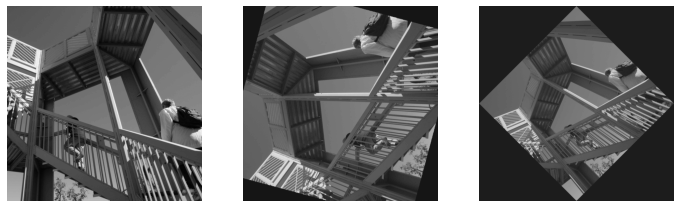

In [7]:
from scipy import ndimage, misc
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 3))
ax1, ax2, ax3 = fig.subplots(1, 3)
img = misc.ascent()
img_45 = ndimage.rotate(img, 75, reshape=False)
full_img_45 = ndimage.rotate(img, 45, reshape=True)
ax1.imshow(img, cmap='gray')
ax1.set_axis_off()
ax2.imshow(img_45, cmap='gray')
ax2.set_axis_off()
ax3.imshow(full_img_45, cmap='gray')
ax3.set_axis_off()
fig.set_tight_layout(True)
plt.show()